### Installing MediaPipe

In [ ]:
%%capture
!pip install mediapipe

### Required Libraries

In [ ]:
import numpy as np
import os,cv2,math,glob,random
import scipy.io as sio
from math import cos, sin
from pathlib import Path
import pandas as pd
import mediapipe
import warnings
warnings.filterwarnings('ignore')
from google.colab.patches import cv2_imshow

### Dowlining Data

In [ ]:
# Loading AFLW2000 Data
%%capture
if os.path.isfile('/content/AFLW2000-3D.zip') == False:
  !gdown --id  1fP3zvSCYjll_o_m7S12nvQLZ9MnsEoap
  !unzip /content/AFLW2000-3D.zip

In [ ]:
def draw_axis(img, pitch,yaw,roll, tdx=None, tdy=None, size = 100):

    yaw = -yaw
    if tdx != None and tdy != None:
        tdx = tdx
        tdy = tdy
    else:
        height, width = img.shape[:2]
        tdx = width / 2
        tdy = height / 2

    # X-Axis pointing to right. drawn in red
    x1 = size * (cos(yaw) * cos(roll)) + tdx
    y1 = size * (cos(pitch) * sin(roll) + cos(roll) * sin(pitch) * sin(yaw)) + tdy

    # Y-Axis | drawn in green
    #        v
    x2 = size * (-cos(yaw) * sin(roll)) + tdx
    y2 = size * (cos(pitch) * cos(roll) - sin(pitch) * sin(yaw) * sin(roll)) + tdy

    # Z-Axis (out of the screen) drawn in blue
    x3 = size * (sin(yaw)) + tdx
    y3 = size * (-cos(yaw) * sin(pitch)) + tdy

    cv2.line(img, (int(tdx), int(tdy)), (int(x1),int(y1)),(0,0,255),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x2),int(y2)),(0,255,0),3)
    cv2.line(img, (int(tdx), int(tdy)), (int(x3),int(y3)),(255,0,0),2)

    return img

### Preparing Data

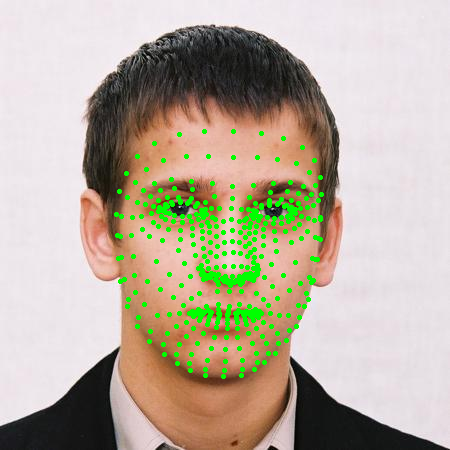

In [ ]:
# choosing random image
random_file = 'image00053'

faceModule = mediapipe.solutions.face_mesh
# loading image and its correspinding mat file
with faceModule.FaceMesh(static_image_mode=True) as faces:
    # loading the image
    image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
    # processing the face to extract the landmark points (468 point) for each x,y,z
    results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks != None:
      # looping over the faces in the image
      for face in results.multi_face_landmarks:
          for landmark in face.landmark:
              x = landmark.x
              y = landmark.y
              # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
              shape = image.shape
              relative_x = int(x * shape[1])
              relative_y = int(y * shape[0])
              # cv2.putText(image, str(relative_y), (int(relative_x),int(relative_y)), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,255,0), 2)
              cv2.circle(image, (relative_x, relative_y), radius=1, color=(0, 255, 0), thickness=2)
      cv2_imshow(image)

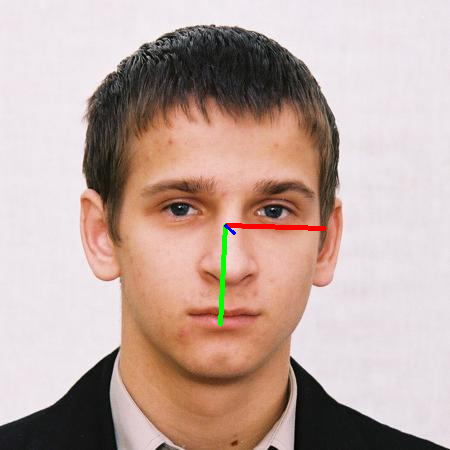

In [ ]:
image = cv2.imread('/content/AFLW2000/'+random_file+'.jpg')
# loading the mat file to extract the 3 angels of the face (pitch,yaw,roll)
mat_file = sio.loadmat('/content/AFLW2000/'+random_file+'.mat')
# extracting the labels 3 angels
pose_para = mat_file["Pose_Para"][0][:3]
pitch = pose_para[0]
yaw = pose_para[1]
roll = pose_para[2]
cv2_imshow(draw_axis(image,pitch,yaw,roll))


In [ ]:
import glob
features_x=[]
features_y=[]
labels=[]
folder_dir = '/content/AFLW2000/'

for images in glob.glob(f'{folder_dir}/*.jpg'):
          faceModule = mediapipe.solutions.face_mesh

          with faceModule.FaceMesh(static_image_mode=True) as faces:
                image = cv2.imread(images)
                #processing the face to extract the landmark points (468 point) for each x,y,z
                results = faces.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                if results.multi_face_landmarks != None:
                  mat_data = sio.loadmat(images[:-3]+'mat')
                  labels.append(mat_data['Pose_Para'][0][:3])

                  # looping over the faces in the image
                  for face in results.multi_face_landmarks:
                      X = []
                      Y = []
                      for landmark in face.landmark:
                          x = landmark.x
                          y = landmark.y
                          # note: the x and y values are scaled to the their width and height so we will get back their actual value in the image
                          shape = image.shape
                          relative_x = int(x * shape[1])
                          relative_y = int(y * shape[0])
                          X.append(relative_x)
                          Y.append(relative_y)
                      features_x.append(X)
                      features_y.append(Y)


features_x = np.array(features_x)
features_y = np.array(features_y)
labels=np.array(labels)
print("features x\n", features_x)
print("features y\n", features_y)
print("labels \n",labels)


features x
 [[217 208 216 ... 231 273 277]
 [224 219 222 ... 234 282 286]
 [238 217 227 ... 209 241 243]
 ...
 [256 269 251 ... 240 245 245]
 [238 242 238 ... 248 302 307]
 [224 222 223 ... 237 288 293]]
features y
 [[299 280 285 ... 234 223 219]
 [296 270 279 ... 224 213 208]
 [292 274 279 ... 227 193 188]
 ...
 [296 268 278 ... 226 216 213]
 [321 296 301 ... 220 195 191]
 [290 262 273 ... 220 213 210]]
labels 
 [[-0.26682413  0.49239531 -0.14005028]
 [ 0.1052172   0.19664778 -0.10837404]
 [-0.04909312  0.33063275 -0.69987023]
 ...
 [ 0.2208941  -1.13306451 -0.17828663]
 [-0.4204753  -0.10520556 -0.04115922]
 [ 0.10747801  0.01424124 -0.03286345]]


In [ ]:
pitch = labels[:,0]
yaw = labels[:,1]
roll=labels[:,2]
pitch , yaw, roll

(array([-0.26682413,  0.1052172 , -0.04909312, ...,  0.2208941 ,
        -0.4204753 ,  0.10747801]),
 array([ 0.49239531,  0.19664778,  0.33063275, ..., -1.13306451,
        -0.10520556,  0.01424124]),
 array([-0.14005028, -0.10837404, -0.69987023, ..., -0.17828663,
        -0.04115922, -0.03286345]))

In [ ]:
x_center = features_x - features_x[:,30].reshape(-1,1)
y_center = features_y - features_y[:,30].reshape(-1,1)



In [ ]:
features_data = np.hstack([x_center,y_center])
features_data

array([[ 32,  23,  31, ...,   9,  -2,  -6],
       [ 61,  56,  59, ...,   6,  -5, -10],
       [ 86,  65,  75, ..., -29, -63, -68],
       ...,
       [ 71,  84,  66, ...,  12,   2,  -1],
       [ 94,  98,  94, ...,  19,  -6, -10],
       [ 67,  65,  66, ...,   8,   1,  -2]])

In [ ]:
features_data.shape, labels.shape


((1853, 936), (1853, 3))

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso,Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

In [ ]:
pitch_X_train, pitch_X_test, pitch_y_train, pitch_y_test = train_test_split(features_data, pitch, test_size=0.2,
                                                                    random_state=42)

yaw_X_train, yaw_X_test, yaw_y_train, yaw_y_test = train_test_split(features_data, yaw, test_size=0.2,
                                                                    random_state=42)

roll_X_train, roll_X_test, roll_y_train, roll_y_test = train_test_split(features_data, roll, test_size=0.2,
                                                                    random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

pitch_xtrain_scaled = scaler.fit_transform(pitch_X_train)
pitch_xtest_scaled = scaler.transform(pitch_X_test)

yaw_xtrain_scaled = scaler.fit_transform(yaw_X_train)
yaw_xtest_scaled = scaler.transform(yaw_X_test)

roll_xtrain_scaled = scaler.fit_transform(roll_X_train)
roll_xtest_scaled = scaler.transform(roll_X_test)

#**Pitch Training**

In [ ]:
pitch_predictor = SVR(degree=3)

pitch_predictor.fit(pitch_xtrain_scaled, pitch_y_train)


SVR()

In [ ]:
print('Training Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtrain_scaled, pitch_y_train))
pitch_score = MSE(pitch_y_train, pitch_predictor.predict(pitch_xtrain_scaled), squared=False)
print("RMSE :", pitch_score)

print()
print('Testing Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtest_scaled, pitch_y_test))
pitch_score = MSE(pitch_y_test, pitch_predictor.predict(pitch_xtest_scaled), squared=False)
print("RMSE :", pitch_score)

Training Scores
R2-Score:  0.2047364629879559
RMSE : 0.5355014170715694

Testing Scores
R2-Score:  0.7999607654046293
RMSE : 0.11389051327154501


In [ ]:

pitch_predictor = RandomForestRegressor()
pitch_predictor.fit(pitch_xtrain_scaled, pitch_y_train)


RandomForestRegressor()

In [ ]:
print('Training Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtrain_scaled, pitch_y_train))
pitch_score = MSE(pitch_y_train, pitch_predictor.predict(pitch_xtrain_scaled), squared=False)
print("RMSE :", pitch_score)

print()
print('Testing Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtest_scaled, pitch_y_test))
pitch_score = MSE(pitch_y_test, pitch_predictor.predict(pitch_xtest_scaled), squared=False)
print("RMSE :", pitch_score)

Training Scores
R2-Score:  0.8508487781185289
RMSE : 0.23190947727070213

Testing Scores
R2-Score:  -0.17785080572078882
RMSE : 0.2763599464118212


In [ ]:
pitch_predictor=DecisionTreeRegressor(random_state=0)
pitch_predictor.fit(pitch_xtrain_scaled, pitch_y_train)


DecisionTreeRegressor(random_state=0)

In [ ]:
print('Training Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtrain_scaled, pitch_y_train))
pitch_score = MSE(pitch_y_train, pitch_predictor.predict(pitch_xtrain_scaled), squared=False)
print("RMSE :", pitch_score)

print()
print('Testing Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtest_scaled, pitch_y_test))
pitch_score = MSE(pitch_y_test, pitch_predictor.predict(pitch_xtest_scaled), squared=False)
print("RMSE :", pitch_score)

Training Scores
R2-Score:  1.0
RMSE : 0.0

Testing Scores
R2-Score:  -9.51551884492849
RMSE : 0.8257437802340472


In [ ]:
pitch_predictor=XGBRegressor()
pitch_predictor.fit(pitch_xtrain_scaled, pitch_y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
print('Training Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtrain_scaled, pitch_y_train))
pitch_score = MSE(pitch_y_train, pitch_predictor.predict(pitch_xtrain_scaled), squared=False)
print("RMSE :", pitch_score)

print()
print('Testing Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtest_scaled, pitch_y_test))
pitch_score = MSE(pitch_y_test, pitch_predictor.predict(pitch_xtest_scaled), squared=False)
print("RMSE :", pitch_score)

Training Scores
R2-Score:  0.999934396684505
RMSE : 0.0048637134870064495

Testing Scores
R2-Score:  0.5883176925901065
RMSE : 0.1633845775862222


In [ ]:
from sklearn import linear_model

pitch_predictor=linear_model.Lasso(alpha=0.1)
pitch_predictor.fit(pitch_xtrain_scaled, pitch_y_train)

Lasso(alpha=0.1)

In [ ]:
print('Training Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtrain_scaled, pitch_y_train))
pitch_score = MSE(pitch_y_train, pitch_predictor.predict(pitch_xtrain_scaled), squared=False)
print("RMSE :", pitch_score)

print()
print('Testing Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtest_scaled, pitch_y_test))
pitch_score = MSE(pitch_y_test, pitch_predictor.predict(pitch_xtest_scaled), squared=False)
print("RMSE :", pitch_score)

Training Scores
R2-Score:  0.07082521306615996
RMSE : 0.5788336860737867

Testing Scores
R2-Score:  0.29826739542244385
RMSE : 0.21331224473941404


In [ ]:
pitch_predictor=linear_model.Ridge(alpha=0.1)
pitch_predictor.fit(pitch_xtrain_scaled, pitch_y_train)

Ridge(alpha=0.1)

In [ ]:
print('Training Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtrain_scaled, pitch_y_train))
pitch_score = MSE(pitch_y_train, pitch_predictor.predict(pitch_xtrain_scaled), squared=False)
print("RMSE :", pitch_score)

print()
print('Testing Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtest_scaled, pitch_y_test))
pitch_score = MSE(pitch_y_test, pitch_predictor.predict(pitch_xtest_scaled), squared=False)
print("RMSE :", pitch_score)

Training Scores
R2-Score:  0.6214928230356018
RMSE : 0.36943849685306873

Testing Scores
R2-Score:  -1.3783369119751794
RMSE : 0.39270519476545634


In [ ]:
from sklearn.linear_model import LinearRegression
pitch_predictor=LinearRegression()
pitch_predictor.fit(pitch_xtrain_scaled, pitch_y_train)

LinearRegression()

In [ ]:
print('Training Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtrain_scaled, pitch_y_train))
pitch_score = MSE(pitch_y_train, pitch_predictor.predict(pitch_xtrain_scaled), squared=False)
print("RMSE :", pitch_score)

print()
print('Testing Scores')

print('R2-Score: ',pitch_predictor.score(pitch_xtest_scaled, pitch_y_test))
pitch_score = MSE(pitch_y_test, pitch_predictor.predict(pitch_xtest_scaled), squared=False)
print("RMSE :", pitch_score)

Training Scores
R2-Score:  0.7253677026212508
RMSE : 0.3146885158364997

Testing Scores
R2-Score:  -6.856671167138326
RMSE : 0.7137551361175676


In [ ]:
#the best is xgboost in pitch

#**Yaw Training**

In [ ]:

yaw_predictor = SVR(degree=3)

yaw_predictor.fit(yaw_xtrain_scaled, yaw_y_train)

SVR()

In [ ]:
print('Training Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtrain_scaled, yaw_y_train))
yaw_score = MSE(yaw_y_train, yaw_predictor.predict(yaw_xtrain_scaled), squared=False)
print("RMSE :", yaw_score)

print()
print('Testing Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtest_scaled, yaw_y_test))
yaw_score = MSE(yaw_y_test, yaw_predictor.predict(yaw_xtest_scaled), squared=False)
print("RMSE :", yaw_score)

Training Scores
R2-Score:  0.8717189229548299
RMSE : 0.2102339070265881

Testing Scores
R2-Score:  0.9608925285715875
RMSE : 0.10910142302417103


In [ ]:
yaw_predictor = RandomForestRegressor()
yaw_predictor.fit(yaw_xtrain_scaled, yaw_y_train)

RandomForestRegressor()

In [ ]:
print('Training Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtrain_scaled, yaw_y_train))
yaw_score = MSE(yaw_y_train, yaw_predictor.predict(yaw_xtrain_scaled), squared=False)
print("RMSE :", yaw_score)

print()
print('Testing Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtest_scaled, yaw_y_test))
yaw_score = MSE(yaw_y_test, yaw_predictor.predict(yaw_xtest_scaled), squared=False)
print("RMSE :", yaw_score)

Training Scores
R2-Score:  0.9730476806471758
RMSE : 0.0963650463283132

Testing Scores
R2-Score:  0.934365597005294
RMSE : 0.1413404001411084


In [ ]:
yaw_predictor = DecisionTreeRegressor()
yaw_predictor.fit(yaw_xtrain_scaled, yaw_y_train)

DecisionTreeRegressor()

In [ ]:
print('Training Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtrain_scaled, yaw_y_train))
yaw_score = MSE(yaw_y_train, yaw_predictor.predict(yaw_xtrain_scaled), squared=False)
print("RMSE :", yaw_score)

print()
print('Testing Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtest_scaled, yaw_y_test))
yaw_score = MSE(yaw_y_test, yaw_predictor.predict(yaw_xtest_scaled), squared=False)
print("RMSE :", yaw_score)

Training Scores
R2-Score:  1.0
RMSE : 0.0

Testing Scores
R2-Score:  0.8650284643718528
RMSE : 0.20268501497740654


In [ ]:
yaw_predictor = XGBRegressor()
yaw_predictor.fit(yaw_xtrain_scaled, yaw_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
print('Training Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtrain_scaled, yaw_y_train))
yaw_score = MSE(yaw_y_train, yaw_predictor.predict(yaw_xtrain_scaled), squared=False)
print("RMSE :", yaw_score)

print()
print('Testing Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtest_scaled, yaw_y_test))
yaw_score = MSE(yaw_y_test, yaw_predictor.predict(yaw_xtest_scaled), squared=False)
print("RMSE :", yaw_score)

Training Scores
R2-Score:  0.9999754837389488
RMSE : 0.0029063544683567517

Testing Scores
R2-Score:  0.9413811757072414
RMSE : 0.13357312870908034


In [ ]:
yaw_predictor = linear_model.Lasso(alpha=0.1)
yaw_predictor.fit(yaw_xtrain_scaled, yaw_y_train)

Lasso(alpha=0.1)

In [ ]:
print('Training Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtrain_scaled, yaw_y_train))
yaw_score = MSE(yaw_y_train, yaw_predictor.predict(yaw_xtrain_scaled), squared=False)
print("RMSE :", yaw_score)

print()
print('Testing Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtest_scaled, yaw_y_test))
yaw_score = MSE(yaw_y_test, yaw_predictor.predict(yaw_xtest_scaled), squared=False)
print("RMSE :", yaw_score)

Training Scores
R2-Score:  0.7647889362198534
RMSE : 0.2846756596275216

Testing Scores
R2-Score:  0.8544415278833427
RMSE : 0.21048409817861585


In [ ]:
yaw_predictor = linear_model.Ridge(alpha=0.1)
yaw_predictor.fit(yaw_xtrain_scaled, yaw_y_train)

Ridge(alpha=0.1)

In [ ]:
print('Training Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtrain_scaled, yaw_y_train))
yaw_score = MSE(yaw_y_train, yaw_predictor.predict(yaw_xtrain_scaled), squared=False)
print("RMSE :", yaw_score)

print()
print('Testing Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtest_scaled, yaw_y_test))
yaw_score = MSE(yaw_y_test, yaw_predictor.predict(yaw_xtest_scaled), squared=False)
print("RMSE :", yaw_score)

Training Scores
R2-Score:  0.9244110165357491
RMSE : 0.161380373045796

Testing Scores
R2-Score:  0.8886517493813864
RMSE : 0.18409510711922478


In [ ]:
yaw_predictor = LinearRegression()
yaw_predictor.fit(yaw_xtrain_scaled, yaw_y_train)

LinearRegression()

In [ ]:
print('Training Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtrain_scaled, yaw_y_train))
yaw_score = MSE(yaw_y_train, yaw_predictor.predict(yaw_xtrain_scaled), squared=False)
print("RMSE :", yaw_score)

print()
print('Testing Scores')

print('R2-Score: ',yaw_predictor.score(yaw_xtest_scaled, yaw_y_test))
yaw_score = MSE(yaw_y_test, yaw_predictor.predict(yaw_xtest_scaled), squared=False)
print("RMSE :", yaw_score)

Training Scores
R2-Score:  0.9443938932108547
RMSE : 0.13841485665563946

Testing Scores
R2-Score:  0.6543766217429853
RMSE : 0.32434118736667117


In [ ]:
#the best in yaw is decision tree

#**Roll Training**

In [ ]:
roll_predictor = RandomForestRegressor()

roll_predictor.fit(roll_xtrain_scaled, roll_y_train )

RandomForestRegressor()

In [ ]:
print('Training Scores')

print('R2-Score: ',roll_predictor.score(roll_xtrain_scaled, roll_y_train))
roll_score = MSE(roll_y_train, roll_predictor.predict(roll_xtrain_scaled), squared=False)
print("MSE :", roll_score)

print()
print('Testing Scores')

print('R2-Score: ',roll_predictor.score(roll_xtest_scaled, roll_y_test))
roll_score = MSE(roll_y_test, roll_predictor.predict(roll_xtest_scaled), squared=False)
print("MSE :", roll_score)

Training Scores
R2-Score:  0.8469118772278736
MSE : 0.2766800667360203

Testing Scores
R2-Score:  -0.12793685963539003
MSE : 0.3460501733517149


In [ ]:
roll_predictor = SVR(degree=3)

roll_predictor.fit(roll_xtrain_scaled, roll_y_train)

SVR()

In [ ]:
print('Training Scores')

print('R2-Score: ',roll_predictor.score(roll_xtrain_scaled, roll_y_train))
roll_score = MSE(roll_y_train, roll_predictor.predict(roll_xtrain_scaled), squared=False)
print("MSE :", roll_score)

print()
print('Testing Scores')

print('R2-Score: ',roll_predictor.score(roll_xtest_scaled, roll_y_test))
roll_score = MSE(roll_y_test, roll_predictor.predict(roll_xtest_scaled), squared=False)
print("MSE :", roll_score)

Training Scores
R2-Score:  0.3224685452853542
MSE : 0.582065493900685

Testing Scores
R2-Score:  0.9132806112513854
MSE : 0.09595216550410776


In [ ]:
roll_predictor = DecisionTreeRegressor()

roll_predictor.fit(roll_xtrain_scaled, roll_y_train)

DecisionTreeRegressor()

In [ ]:
print('Training Scores')

print('R2-Score: ',roll_predictor.score(roll_xtrain_scaled, roll_y_train))
roll_score = MSE(roll_y_train, roll_predictor.predict(roll_xtrain_scaled), squared=False)
print("MSE :", roll_score)

print()
print('Testing Scores')

print('R2-Score: ',roll_predictor.score(roll_xtest_scaled, roll_y_test))
roll_score = MSE(roll_y_test, roll_predictor.predict(roll_xtest_scaled), squared=False)
print("MSE :", roll_score)

Training Scores
R2-Score:  1.0
MSE : 0.0

Testing Scores
R2-Score:  -5.500637217269862
MSE : 0.8307582093078881


In [ ]:
roll_predictor = XGBRegressor()

roll_predictor.fit(roll_xtrain_scaled, roll_y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
print('Training Scores')

print('R2-Score: ',roll_predictor.score(roll_xtrain_scaled, roll_y_train))
roll_score = MSE(roll_y_train, roll_predictor.predict(roll_xtrain_scaled), squared=False)
print("MSE :", roll_score)

print()
print('Testing Scores')

print('R2-Score: ',roll_predictor.score(roll_xtest_scaled, roll_y_test))
roll_score = MSE(roll_y_test, roll_predictor.predict(roll_xtest_scaled), squared=False)
print("MSE :", roll_score)

Training Scores
R2-Score:  0.9999883635796704
MSE : 0.0024122194958675867

Testing Scores
R2-Score:  0.8670922438436347
MSE : 0.11878780013243206


In [ ]:
roll_predictor =linear_model.Lasso(alpha=0.1)

roll_predictor.fit(roll_xtrain_scaled, roll_y_train )

Lasso(alpha=0.1)

In [ ]:
print('Training Scores')

print('R2-Score: ',roll_predictor.score(roll_xtrain_scaled, roll_y_train))
roll_score = MSE(roll_y_train, roll_predictor.predict(roll_xtrain_scaled), squared=False)
print("MSE :", roll_score)

print()
print('Testing Scores')

print('R2-Score: ',roll_predictor.score(roll_xtest_scaled, roll_y_test))
roll_score = MSE(roll_y_test, roll_predictor.predict(roll_xtest_scaled), squared=False)
print("MSE :", roll_score)

Training Scores
R2-Score:  0.2428987169055331
MSE : 0.6152960315787748

Testing Scores
R2-Score:  0.7363647732290595
MSE : 0.16730094595084902


In [ ]:
roll_predictor =linear_model.Ridge(alpha=0.1)

roll_predictor.fit(roll_xtrain_scaled, roll_y_train )

Ridge(alpha=0.1)

In [ ]:
print('Training Scores')

print('R2-Score: ',roll_predictor.score(roll_xtrain_scaled, roll_y_train))
roll_score = MSE(roll_y_train, roll_predictor.predict(roll_xtrain_scaled), squared=False)
print("MSE :", roll_score)

print()
print('Testing Scores')

print('R2-Score: ',roll_predictor.score(roll_xtest_scaled, roll_y_test))
roll_score = MSE(roll_y_test, roll_predictor.predict(roll_xtest_scaled), squared=False)
print("MSE :", roll_score)

Training Scores
R2-Score:  0.7808201063568857
MSE : 0.3310605855751254

Testing Scores
R2-Score:  -0.6410923216073496
MSE : 0.4174103209797391


In [ ]:
roll_predictor =LinearRegression()

roll_predictor.fit(roll_xtrain_scaled, roll_y_train )

LinearRegression()

In [ ]:
print('Training Scores')

print('R2-Score: ',roll_predictor.score(roll_xtrain_scaled, roll_y_train))
roll_score = MSE(roll_y_train, roll_predictor.predict(roll_xtrain_scaled), squared=False)
print("MSE :", roll_score)

print()
print('Testing Scores')

print('R2-Score: ',roll_predictor.score(roll_xtest_scaled, roll_y_test))
roll_score = MSE(roll_y_test, roll_predictor.predict(roll_xtest_scaled), squared=False)
print("MSE :", roll_score)

Training Scores
R2-Score:  0.8484644293232463
MSE : 0.27527350798445954

Testing Scores
R2-Score:  -3.6408277804698645
MSE : 0.7019309672028636


In [ ]:
#xgboost is the best in roll

#**Training with the best model in each**

In [ ]:
pitch_predictor=XGBRegressor()
pitch_predictor.fit(pitch_xtrain_scaled, pitch_y_train)
yaw_predictor = DecisionTreeRegressor()
yaw_predictor.fit(yaw_xtrain_scaled, yaw_y_train)
roll_predictor = XGBRegressor()
roll_predictor.fit(roll_xtrain_scaled, roll_y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
pitch_test=pitch_predictor.predict(pitch_X_test)
yaw_test=yaw_predictor.predict(yaw_X_test)
roll_test=roll_predictor.predict(roll_X_test)


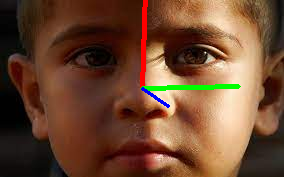

In [ ]:
import cv2
import mediapipe as mp
import statistics


face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)


image = cv2.imread('/content/images.jpg')


image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = face_mesh.process(image_rgb)


if results.multi_face_landmarks:

    nose_landmark = results.multi_face_landmarks[0].landmark[5]
    nose_x = int(nose_landmark.x * image.shape[1])
    nose_y = int(nose_landmark.y * image.shape[0])

    image_with_axes = draw_axis(image, pitch_test[0], yaw_test[0], roll_test[0], nose_x, nose_y)

    cv2_imshow(image_with_axes)


face_mesh.close()


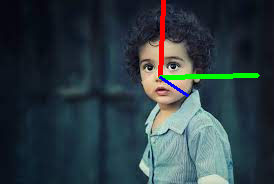

In [ ]:
import cv2
import mediapipe as mp
import statistics
X=[]
Y=[]

face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)


image = cv2.imread('/content/download (1).jpg')


image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = face_mesh.process(image_rgb)


if results.multi_face_landmarks:

    nose_landmark = results.multi_face_landmarks[0].landmark
    for landmark in results.multi_face_landmarks[0].landmark:
        x = int(landmark.x * image.shape[1])
        y = int(landmark.y * image.shape[0])
        X.append(x)
        Y.append(y)
    nose_x=statistics.mean(X)
    nose_y=statistics.mean(Y)
    #nose_x = int(nose_landmark.x * image.shape[1])
    #nose_y = int(nose_landmark.y * image.shape[0])


    image_with_axes = draw_axis(image, pitch_test[0], yaw_test[0], roll_test[0], nose_x, nose_y)

    cv2_imshow(image_with_axes)


face_mesh.close()


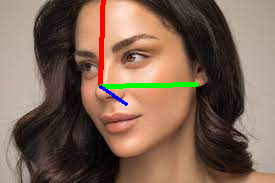

In [ ]:
import cv2
import mediapipe as mp
import statistics

face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)

image = cv2.imread('/content/download (3).jpg')

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = face_mesh.process(image_rgb)

if results.multi_face_landmarks:

    nose_landmark = results.multi_face_landmarks[0].landmark[5]

    nose_x = int(nose_landmark.x * image.shape[1])
    nose_y = int(nose_landmark.y * image.shape[0])

    image_with_axes = draw_axis(image, pitch_test[0], yaw_test[0], roll_test[0], nose_x, nose_y)

    cv2_imshow(image_with_axes)

face_mesh.close()


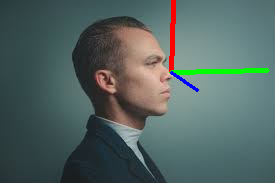

In [ ]:
import cv2
import mediapipe as mp
import statistics


face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)

image = cv2.imread('/content/download (2).jpg')

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

results = face_mesh.process(image_rgb)

if results.multi_face_landmarks:

    nose_landmark = results.multi_face_landmarks[0].landmark[5]

    nose_x = int(nose_landmark.x * image.shape[1])
    nose_y = int(nose_landmark.y * image.shape[0])

    image_with_axes = draw_axis(image, pitch_test[0], yaw_test[0], roll_test[0], nose_x, nose_y)

    cv2_imshow(image_with_axes)

face_mesh.close()


In [ ]:
import cv2
import mediapipe as mp

face_mesh = mp.solutions.face_mesh.FaceMesh(static_image_mode=True)

input_video_path ='/content/الدحيح الناس صارت بتهرب من الحياة العادية.mp4'

cap = cv2.VideoCapture(input_video_path)

output_video_path = '/content/output_video.mp4'
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, 30.0, (640, 480))  # Change resolution as needed

while cap.isOpened():

    ret, frame = cap.read()
    if not ret:
        break


    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


    results = face_mesh.process(frame_rgb)


    if results.multi_face_landmarks:

        nose_landmark = results.multi_face_landmarks[0].landmark[5]
        nose_x = int(nose_landmark.x * frame.shape[1])
        nose_y = int(nose_landmark.y * frame.shape[0])

        frame_with_axes = draw_axis(frame, pitch_test[0], yaw_test[0], roll_test[0], nose_x, nose_y)

        frame_with_axes = cv2.resize(frame_with_axes, (640, 480))  # Change resolution as needed

        out.write(frame_with_axes)

cap.release()
out.release()
face_mesh.close()

print("Video saved successfully.")


Video saved successfully.
